# Walk-through FitLins Analysis

This document demonstrates the command line to run a FitLins analysis.

We use the [OpenNeuro](https://openneuro.org) dataset [ds000003](https://openneuro.org/datasets/ds000003/),
with [fMRIPrep](https://fmriprep.rtfd.io)-preprocessed results at
[///labs/poldrack/ds003_fmriprep](http://datasets.datalad.org/?dir=/labs/poldrack/ds003_fmriprep).

## Preamble

We will use [Datalad](https://www.datalad.org) to manage our data, which in turn depends on `git-annex`. To install `git-annex`, uncomment and run one of the following:

In [1]:
# Debian
# apt-get install git-annex

In [2]:
# Linux with Conda
# conda install -y git-annex

In [3]:
# OSX
# open https://git-annex.branchable.com/install/OSX/

Datalad and FitLins are Python tools.
To ensure that everything installs correctly, we'll upgrade the [pip](https://pip.pypa.io/en/stable/) package manager
and the [setuptools](https://setuptools.readthedocs.io/en/latest/) utilities.

We will also install unreleased versions of Datalad and [Nistats](https://nistats.github.io/) to make things run a little more smoothly.

In [2]:
! pip install -q --upgrade pip setuptools
! pip install -q --upgrade datalad nistats

## Install data and FitLins

First, install the [dataset](http://datasets.datalad.org/?dir=/labs/poldrack/ds003_fmriprep) we'll be working with.

In [4]:
# Set environment variable to make outputs more friendly
!export DATALAD_UI_PROGRESSBAR=log
!export NO_COLOR="1"

!datalad install -r ///labs/poldrack/ds003_fmriprep
!datalad update ds003_fmriprep

Clone attempt: 100%|███████| 2.00/2.00 [00:00<00:00, 2.75 Candidate locations/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                              | 0.00/68.6k [00:00<?, ? Objects/s]
Counting:   1%|▏                      | 687/68.6k [00:00<00:14, 4.83k Objects/s]
Counting:  24%|█████                | 16.5k/68.6k [00:00<00:00, 81.5k Objects/s]
                                                                                
Compressing:   0%|                           | 0.00/37.4k [00:00<?, ? Objects/s]
Compressing:  28%|█████▎             | 10.5k/37.4k [00:00<00:00, 104k Objects/s]
Compressing:  56%|██████████        | 21.0k/37.4k [00:00<00:00, 79.9k Objects/s]
Compressing:  79%|██████████████▏   | 29.6k/37.4k [00:00<00:00, 73.2k Objects/s]
Compressing: 100%|██████████████████| 37.4k/37.4k [00:00<00:00, 70.3k Objects/s]
                                                                                
Receiving:   0%

Fetch the preprocessed BOLD series and calculated confounds for the all subjects.

In [15]:
! datalad get ds003_fmriprep/sub-*/func/*_space-MNI152NLin2009cAsym_desc-*.nii.gz \
            ds003_fmriprep/sub-*/func/*_desc-confounds_*.tsv \
            ds003_fmriprep/sub-*/func/*_desc-confounds_*.json \
            ds003_fmriprep/dataset_description.json \ 

get(ok): examples/notebooks/ds003_fmriprep/sub-04/func/sub-04_task-rhymejudgment_desc-confounds_regressors.json (file) [from origin...]
get(ok): examples/notebooks/ds003_fmriprep/sub-12/func/sub-12_task-rhymejudgment_desc-confounds_regressors.json (file) [from origin...]
get(ok): examples/notebooks/ds003_fmriprep/sub-02/func/sub-02_task-rhymejudgment_desc-confounds_regressors.json (file) [from origin...]
get(ok): examples/notebooks/ds003_fmriprep/sub-06/func/sub-06_task-rhymejudgment_desc-confounds_regressors.json (file) [from origin...]
get(ok): examples/notebooks/ds003_fmriprep/sub-05/func/sub-05_task-rhymejudgment_desc-confounds_regressors.json (file) [from origin...]
get(ok): examples/notebooks/ds003_fmriprep/sub-13/func/sub-13_task-rhymejudgment_desc-confounds_regressors.json (file) [from origin...]
get(ok): examples/notebooks/ds003_fmriprep/sub-01/func/sub-01_task-rhymejudgment_desc-confounds_regressors.json (file) [from origin...]
get(ok): examples/notebooks/ds003_fmriprep/sub-1

Finally, install FitLins via pip. See the [Installation](https://fitlins.readthedocs.io/en/latest/installation.html)
section of the documentation for instructions on using Docker or Singularity. For the purposes of this tutorial,
however, we'll assume you can install to your current Python environment without issue.

In [7]:
! pip install -q --upgrade fitlins

## Dataset structure

This dataset is organized as an fMRIPrep derivatives directory, with the original dataset included as the `sourcedata/` sub-dataset.
The following command shows just the directories for the first three subjects. (Will probably not work with earlier versions than `tree 1.8.0`.)

In [9]:
! tree -P "sub-0[123]*.nii.gz" -I "figures|log" --prune --noreport ds003_fmriprep | grep -v -- '->'

ds003_fmriprep
├── sourcedata
│   ├── sub-01
│   │   ├── anat
│   │   └── func
│   ├── sub-02
│   │   ├── anat
│   │   └── func
│   └── sub-03
│       ├── anat
│       └── func
├── sub-01
│   ├── anat
│   └── func
├── sub-02
│   ├── anat
│   └── func
└── sub-03
    ├── anat
    └── func


### Model

We will estimate the model found in `../models/ds000003/models/model-001_smdl.json`:

In [10]:
!cat ../models/ds000003/models/model-001_smdl.json

{
   "Name":"ds003_model001",
   "BIDSModelVersion":"1.0.0",
   "Description":"",
   "Input":{
      "task":"rhymejudgment"
   },
   "Nodes":[
      {
         "Level":"run",
         "Name":"subject",
         "GroupBy":[
            "subject"
         ],
         "Transformations":{
            "Transformer":"pybids-transforms-v1",
            "Instructions":[
               {
                  "Name":"Factor",
                  "Input":[
                     "trial_type"
                  ]
               },
               {
                  "Name":"Convolve",
                  "Input":[
                     "trial_type.word",
                     "trial_type.pseudoword"
                  ],
                  "Model":"spm"
               }
            ]
         },
         "Model":{
            "X":[
               "trial_type.word",
               "trial_type.pseudoword",
               "framewise_displacement",
               "trans_x",
               "trans_y",
               "

## Running FitLins

A BIDS App takes a BIDS dataset, a target directory and an analysis level. Use the BIDS-Raw dataset (`ds003_fmriprep/sourcedata`) as the dataset, and we'll create a new directory `output`. The `dataset` level indicates the highest level of analysis, so `run`, `session` and `subject` will be run, if found in the model.

In addition, we pass `ds003_fmriprep` as with the `--derivatives` (or `-d`) flag, indicating that preprocessed data should be found there. We will also pass the model from `openfmri/ds000003/model.json`

In [16]:
! fitlins ds003_fmriprep/sourcedata output/ dataset \
    --derivatives $PWD/ds003_fmriprep \
    --model $PWD/../models/ds000003/models/model-001_smdl.json \
    --smoothing 5:run \
    -w scratch \
    --n-cpus 2

Captured warning (<class 'UserWarning'>): The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
Captured warning (<class 'FutureWarning'>): Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
220616-18:26:06,737 nipype.workflow INFO:
	 [Node] Setting-up "fitlins_wf.loader" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/loader".
220616-18:26:06,742 nipype.workflow INFO:
	 [Node] Executing "loader" <fitlins.interfaces.bids.LoadBIDSModel>
/Users/nielsond/code/pybids/fitlins_test_env/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
220616-18

220616-18:26:46,464 nipype.workflow INFO:
	 [Node] Finished "_design_matrix12", elapsed time 0.015171s.
220616-18:26:48,466 nipype.workflow INFO:
	 [Node] Setting-up "_design_matrix0" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/design_matrix/mapflow/_design_matrix0".
220616-18:26:48,468 nipype.workflow INFO:
	 [Node] Cached "_design_matrix0" - collecting precomputed outputs
220616-18:26:48,469 nipype.workflow INFO:
	 [Node] "_design_matrix0" found cached.
220616-18:26:48,470 nipype.workflow INFO:
	 [Node] Setting-up "_design_matrix1" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/design_matrix/mapflow/_design_matrix1".
220616-18:26:48,472 nipype.workflow INFO:
	 [Node] Cached "_design_matrix1" - collecting precomputed outputs
220616-18:26:48,473 nipype.workflow INFO:
	 [Node] "_design_matrix1" found cached.
220616-18:26:48,474 nipype.workflow INFO:
	 [Node] Setting-up "_design_matrix2" in "/Users/nielsond/code/pybids/fitl

220616-18:26:58,468 nipype.workflow INFO:
	 [Node] Executing "_plot_design7" <fitlins.interfaces.visualizations.DesignPlot>
220616-18:26:58,666 nipype.workflow INFO:
	 [Node] Finished "_plot_design6", elapsed time 0.197373s.
220616-18:26:58,672 nipype.workflow INFO:
	 [Node] Finished "_plot_design7", elapsed time 0.202535s.
220616-18:27:00,468 nipype.workflow INFO:
	 [Node] Setting-up "_plot_design8" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_design/mapflow/_plot_design8".
220616-18:27:00,469 nipype.workflow INFO:
	 [Node] Setting-up "_plot_design9" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_design/mapflow/_plot_design9".
220616-18:27:00,472 nipype.workflow INFO:
	 [Node] Executing "_plot_design8" <fitlins.interfaces.visualizations.DesignPlot>
220616-18:27:00,473 nipype.workflow INFO:
	 [Node] Executing "_plot_design9" <fitlins.interfaces.visualizations.DesignPlot>
220616-18:27:00,672 nipype.workflow INFO:


220616-18:27:06,629 nipype.workflow INFO:
	 [Node] Finished "_plot_run_contrast_matrix1", elapsed time 0.136756s.
220616-18:27:08,503 nipype.workflow INFO:
	 [Node] Setting-up "_plot_run_contrast_matrix2" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_run_contrast_matrix/mapflow/_plot_run_contrast_matrix2".
220616-18:27:08,504 nipype.workflow INFO:
	 [Node] Setting-up "_plot_run_contrast_matrix3" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_run_contrast_matrix/mapflow/_plot_run_contrast_matrix3".
220616-18:27:08,507 nipype.workflow INFO:
	 [Node] Executing "_plot_run_contrast_matrix2" <fitlins.interfaces.visualizations.ContrastMatrixPlot>
220616-18:27:08,508 nipype.workflow INFO:
	 [Node] Executing "_plot_run_contrast_matrix3" <fitlins.interfaces.visualizations.ContrastMatrixPlot>
220616-18:27:08,638 nipype.workflow INFO:
	 [Node] Finished "_plot_run_contrast_matrix3", elapsed time 0.128457s.
220616-18:27:08,639 

220616-18:27:20,790 nipype.workflow INFO:
	 [Node] Finished "_plot_corr1", elapsed time 0.281132s.
220616-18:27:22,528 nipype.workflow INFO:
	 [Node] Setting-up "_plot_corr2" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_corr/mapflow/_plot_corr2".
220616-18:27:22,529 nipype.workflow INFO:
	 [Node] Setting-up "_plot_corr3" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_corr/mapflow/_plot_corr3".
220616-18:27:22,532 nipype.workflow INFO:
	 [Node] Executing "_plot_corr2" <fitlins.interfaces.visualizations.DesignCorrelationPlot>
220616-18:27:22,534 nipype.workflow INFO:
	 [Node] Executing "_plot_corr3" <fitlins.interfaces.visualizations.DesignCorrelationPlot>
220616-18:27:22,819 nipype.workflow INFO:
	 [Node] Finished "_plot_corr2", elapsed time 0.283816s.
220616-18:27:22,821 nipype.workflow INFO:
	 [Node] Finished "_plot_corr3", elapsed time 0.284728s.
220616-18:27:24,506 nipype.workflow INFO:
	 [Node] Setting-up "_p

220616-18:27:36,568 nipype.workflow INFO:
	 [Node] Setting-up "_deindex_tsv2" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/deindex_tsv/mapflow/_deindex_tsv2".
220616-18:27:36,569 nipype.workflow INFO:
	 [Node] Setting-up "_deindex_tsv3" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/deindex_tsv/mapflow/_deindex_tsv3".
220616-18:27:36,571 nipype.workflow INFO:
	 [Node] Executing "_deindex_tsv2" <nipype.interfaces.utility.wrappers.Function>
220616-18:27:36,572 nipype.workflow INFO:
	 [Node] Executing "_deindex_tsv3" <nipype.interfaces.utility.wrappers.Function>
220616-18:27:36,581 nipype.workflow INFO:
	 [Node] Finished "_deindex_tsv2", elapsed time 0.007815s.
220616-18:27:36,581 nipype.workflow INFO:
	 [Node] Finished "_deindex_tsv3", elapsed time 0.007458s.
220616-18:27:38,532 nipype.workflow INFO:
	 [Node] Setting-up "_deindex_tsv4" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/deindex_tsv/

220616-18:27:50,605 nipype.workflow INFO:
	 [Node] Setting-up "_l1_model1" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model1".
220616-18:27:50,690 nipype.workflow INFO:
	 [Node] Executing "_l1_model1" <fitlins.interfaces.nistats.FirstLevelModel>
220616-18:28:16,212 nipype.workflow INFO:
	 [Node] Finished "_l1_model0", elapsed time 29.588876s.
220616-18:28:16,601 nipype.workflow INFO:
	 [Node] Setting-up "_l1_model2" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model2".
220616-18:28:16,673 nipype.workflow INFO:
	 [Node] Executing "_l1_model2" <fitlins.interfaces.nistats.FirstLevelModel>
220616-18:28:20,734 nipype.workflow INFO:
	 [Node] Finished "_l1_model1", elapsed time 30.042067s.
220616-18:28:22,624 nipype.workflow INFO:
	 [Node] Setting-up "_l1_model3" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model3".
220616-18:28:22

220616-18:31:21,870 nipype.workflow INFO:
	 [Node] Cached "_l1_model9" - collecting precomputed outputs
220616-18:31:21,871 nipype.workflow INFO:
	 [Node] "_l1_model9" found cached.
220616-18:31:21,872 nipype.workflow INFO:
	 [Node] Setting-up "_l1_model10" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model10".
220616-18:31:21,889 nipype.workflow INFO:
	 [Node] Cached "_l1_model10" - collecting precomputed outputs
220616-18:31:21,890 nipype.workflow INFO:
	 [Node] "_l1_model10" found cached.
220616-18:31:21,891 nipype.workflow INFO:
	 [Node] Setting-up "_l1_model11" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model11".
220616-18:31:21,907 nipype.workflow INFO:
	 [Node] Cached "_l1_model11" - collecting precomputed outputs
220616-18:31:21,908 nipype.workflow INFO:
	 [Node] "_l1_model11" found cached.
220616-18:31:21,909 nipype.workflow INFO:
	 [Node] Setting-up "_l1_model12" in "

220616-18:31:46,473 nipype.workflow INFO:
	 [Node] Finished "_plot_subject_contrasts5", elapsed time 1.284749s.
220616-18:31:46,500 nipype.workflow INFO:
	 [Node] Finished "_plot_subject_contrasts6", elapsed time 1.31921s.
220616-18:31:47,185 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts7" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts7".
220616-18:31:47,190 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts7" <fitlins.interfaces.visualizations.GlassBrainPlot>
220616-18:31:47,186 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts8" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts8".
220616-18:31:47,196 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts8" <fitlins.interfaces.visualizations.GlassBrainPlot>
220616-18:31:48,477 nipype.workflow INFO:
	 [Node

220616-18:32:04,500 nipype.workflow INFO:
	 [Node] Finished "_plot_subject_contrasts23", elapsed time 1.283313s.
220616-18:32:04,542 nipype.workflow INFO:
	 [Node] Finished "_plot_subject_contrasts24", elapsed time 1.321432s.
220616-18:32:05,217 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts26" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts26".
220616-18:32:05,216 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts25" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts25".
220616-18:32:05,221 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts26" <fitlins.interfaces.visualizations.GlassBrainPlot>
220616-18:32:05,223 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts25" <fitlins.interfaces.visualizations.GlassBrainPlot>
220616-18:32:06,534 nipype.workflow INFO

220616-18:32:22,535 nipype.workflow INFO:
	 [Node] Finished "_plot_subject_contrasts41", elapsed time 1.279073s.
220616-18:32:22,542 nipype.workflow INFO:
	 [Node] Finished "_plot_subject_contrasts42", elapsed time 1.283482s.
220616-18:32:23,249 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts43" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts43".
220616-18:32:23,250 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts44" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts44".
220616-18:32:23,255 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts44" <fitlins.interfaces.visualizations.GlassBrainPlot>
220616-18:32:23,255 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts43" <fitlins.interfaces.visualizations.GlassBrainPlot>
220616-18:32:24,554 nipype.workflow INFO

220616-18:32:33,335 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts15" found cached.
220616-18:32:33,336 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts16" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts16".
220616-18:32:33,337 nipype.workflow INFO:
	 [Node] Cached "_plot_subject_contrasts16" - collecting precomputed outputs
220616-18:32:33,337 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts16" found cached.
220616-18:32:33,338 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts17" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts17".
220616-18:32:33,339 nipype.workflow INFO:
	 [Node] Cached "_plot_subject_contrasts17" - collecting precomputed outputs
220616-18:32:33,339 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts17" found cached.
220616-18:32:33,340 nipype.wo

220616-18:32:33,385 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts37" found cached.
220616-18:32:33,386 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts38" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts38".
220616-18:32:33,387 nipype.workflow INFO:
	 [Node] Cached "_plot_subject_contrasts38" - collecting precomputed outputs
220616-18:32:33,388 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts38" found cached.
220616-18:32:33,388 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts39" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts39".
220616-18:32:33,390 nipype.workflow INFO:
	 [Node] Cached "_plot_subject_contrasts39" - collecting precomputed outputs
220616-18:32:33,390 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts39" found cached.
220616-18:32:33,391 nipype.wo

# running fitlins with 3dREMLfit

To use 3dREMLfit, we'll need to install AFNI, for our purposes the version on conda should be fine.

In [19]:
!conda install -y -c leej3 -c conda-forge afni-minimal

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/nielsond/code/pybids/fitlins_test_env

  added / updated specs:
    - afni-minimal


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    afni-minimal-AFNI_20.3.01  |       h92b9ce3_0         8.0 MB  leej3
    ------------------------------------------------------------
                                           Total:         8.0 MB

The following NEW packages will be INSTALLED:

  afni-minimal       leej3/osx-64::afni-minimal-AFNI_20.3.01-h92b9ce3_0



afni-minimal-AFNI_20 | 8.0 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [20]:
! fitlins ds003_fmriprep/sourcedata output_reml/ dataset \
    --derivatives $PWD/ds003_fmriprep \
    --model $PWD/../models/ds000003/models/model-001_smdl.json \
    --smoothing 5:run \
    -w scratch \
    --n-cpus 2 \
    --estimator afni

Captured warning (<class 'UserWarning'>): The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
Captured warning (<class 'FutureWarning'>): Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
220617-10:49:38,271 nipype.workflow INFO:
	 [Node] Setting-up "_smooth0" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/smooth/mapflow/_smooth0".
220617-10:49:38,275 nipype.workflow INFO:
	 [Node] Executing "_smooth0" <nipype.interfaces.afni.preprocess.BlurInMask>
220617-10:49:42,287 nipype.workflow INFO:
	 [Node] Setting-up "_smooth1" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/smooth/mapflow/_smooth1".
220617-10:49:42,291 nipype.workflow INFO:
	 [Node] Executing "_smooth1" <nipype.interfaces.afni.preprocess.BlurInMask>
220617-10:49:53,879

220617-10:52:09,932 nipype.workflow INFO:
	 [Node] Setting-up "_l1_model0" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model0".
220617-10:52:09,932 nipype.workflow INFO:
	 [Node] Outdated cache found for "_l1_model0".
220617-10:52:09,975 nipype.workflow INFO:
	 [Node] Executing "_l1_model0" <fitlins.interfaces.afni.FirstLevelModel>
/Users/nielsond/code/pybids/fitlins_test_env/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/Users/nielsond/code/pybids/fitlins_test_env/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
220617-10:52

220617-10:54:06,877 nipype.interface INFO:
	 stderr 2022-06-17T10:54:06.876622:++ REML voxel loop: 0123456789.0123456789.0123456789.0123456789.0123456789.
220617-10:54:06,877 nipype.interface INFO:
	 stderr 2022-06-17T10:54:06.877418: + ARMA voxel parameters estimated: total CPU=100.88 Elapsed=102.05
220617-10:54:06,884 nipype.interface INFO:
	 stderr 2022-06-17T10:54:06.883698:++ Ljung-Box max lag parameter h = 33 (31 chi-squared DOF)
220617-10:54:10,912 nipype.interface INFO:
	 stderr 2022-06-17T10:54:10.911998:++ REML voxel loop: 0123456789.0123456789.0123456789.0123456789.0123456789.
220617-10:54:10,912 nipype.interface INFO:
	 stderr 2022-06-17T10:54:10.911998: + ARMA voxel parameters estimated: total CPU=106.65 Elapsed=107.80
220617-10:54:10,919 nipype.interface INFO:
	 stderr 2022-06-17T10:54:10.918536:++ Ljung-Box max lag parameter h = 33 (31 chi-squared DOF)
220617-10:54:22,476 nipype.interface INFO:
	 stderr 2022-06-17T10:54:22.475693:++ GLSQ loop:0123456789.0123456789.012345

220617-10:54:49,524 nipype.interface INFO:
	 stderr 2022-06-17T10:54:49.524178:++ Smallest FDR q [9 stim_trial_type.word_Fstat] = 5.03432e-13
220617-10:54:50,499 nipype.interface INFO:
	 stderr 2022-06-17T10:54:50.499149:++ Output dataset ./glt_results.nii.gz
220617-10:54:50,512 nipype.interface INFO:
	 stderr 2022-06-17T10:54:50.512314: + unloading input dataset and REML matrices
220617-10:54:50,532 nipype.interface INFO:
	 stderr 2022-06-17T10:54:50.531697:++ 3dREMLfit is all done! total CPU=142.19 Elapsed=145.71
220617-10:54:50,573 nipype.interface INFO:
	 stderr 2022-06-17T10:54:50.573201:++ Smallest FDR q [11 word_gt_pseudo#0_Tstat] = 0.0678971
220617-10:54:50,705 nipype.interface INFO:
	 stderr 2022-06-17T10:54:50.705547:++ Smallest FDR q [12 word_gt_pseudo_R^2] = 0.0678971
220617-10:54:50,829 nipype.interface INFO:
	 stderr 2022-06-17T10:54:50.829460:++ Smallest FDR q [13 word_gt_pseudo_Fstat] = 0.0678972
220617-10:54:51,123 nipype.interface INFO:
	 stderr 2022-06-17T10:54:51.12

220617-10:57:52,265 nipype.interface INFO:
	 3dREMLfit and 3dPval computation will be performed in: /Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model3

220617-10:57:52,309 nipype.interface INFO:
	 stderr 2022-06-17T10:57:52.309259:++ 3dREMLfit: AFNI version=AFNI_20.3.01 (Nov  5 2020) [64-bit]
220617-10:57:52,310 nipype.interface INFO:
	 stderr 2022-06-17T10:57:52.310590:++ Authored by: RWCox
220617-10:57:52,311 nipype.interface INFO:
	 stderr 2022-06-17T10:57:52.311257:** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model3/sub-04_task-rhymejudgment_space-MNI152NLin2009cAsym_desc-preproc_bold_blur_scaled.nii.gz to FLOAT32
220617-10:57:52,311 nipype.interface INFO:
	 stderr 2022-06-17T10:57:52.311257:     Warnings of this type will be muted for this session.
220617-10:57:52,312 nipype.interface INFO:
	 stderr 2022-06-17T10:57:52.311257:   

220617-11:00:07,944 nipype.interface INFO:
	 stderr 2022-06-17T11:00:07.944394:++ Smallest FDR q [5 stim_trial_type.pseudoword_Fstat] = 7.33479e-13
220617-11:00:09,17 nipype.interface INFO:
	 stderr 2022-06-17T11:00:09.016702:++ Smallest FDR q [7 stim_trial_type.word#0_Tstat] = 2.6125e-13
220617-11:00:09,158 nipype.interface INFO:
	 stderr 2022-06-17T11:00:09.157820:++ Smallest FDR q [8 stim_trial_type.word_R^2] = 2.6125e-13
220617-11:00:09,293 nipype.interface INFO:
	 stderr 2022-06-17T11:00:09.293281:++ Smallest FDR q [9 stim_trial_type.word_Fstat] = 2.6125e-13
220617-11:00:10,265 nipype.interface INFO:
	 stderr 2022-06-17T11:00:10.264963:++ Smallest FDR q [11 word_gt_pseudo#0_Tstat] = 0.0583683
220617-11:00:10,391 nipype.interface INFO:
	 stderr 2022-06-17T11:00:10.391300:++ Smallest FDR q [12 word_gt_pseudo_R^2] = 0.0583682
220617-11:00:10,511 nipype.interface INFO:
	 stderr 2022-06-17T11:00:10.510676:++ Smallest FDR q [13 word_gt_pseudo_Fstat] = 0.0583683
220617-11:00:11,520 nipyp

220617-11:02:34,833 nipype.interface INFO:
	 stderr 2022-06-17T11:02:34.833263:++ Processing:++-+++-+++-+++-+++-+++-+++
220617-11:02:35,870 nipype.interface INFO:
	 stderr 2022-06-17T11:02:35.870465:++ Output dataset ./pval_maps.nii.gz
220617-11:02:44,673 nipype.interface INFO:
	 stderr 2022-06-17T11:02:44.672788:++ Processing:++-+++-+++-+++-+++-+++-+++
220617-11:02:45,920 nipype.interface INFO:
	 stderr 2022-06-17T11:02:45.919494:++ Output dataset ./zscore_maps.nii.gz
/Users/nielsond/code/pybids/fitlins_test_env/lib/python3.10/site-packages/fitlins/interfaces/afni.py:312: RuntimeWarning: invalid value encountered in true_divide
  variance = (effect / stat) ** 2
220617-11:02:50,57 nipype.workflow INFO:
	 [Node] Finished "_l1_model2", elapsed time 315.547275s.
220617-11:02:51,30 nipype.workflow INFO:
	 [Node] Setting-up "_l1_model4" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model4".
220617-11:02:51,31 nipype.workflow INFO:
	 [Node

220617-11:03:39,32 nipype.interface INFO:
	 stderr 2022-06-17T11:03:39.031832:++ Converting input dataset to vector image
220617-11:03:39,32 nipype.interface INFO:
	 stderr 2022-06-17T11:03:39.031832: +  dataset = 693 million bytes
220617-11:03:39,32 nipype.interface INFO:
	 stderr 2022-06-17T11:03:39.031832: +  vectim  = 171 million bytes
220617-11:03:39,641 nipype.interface INFO:
	 stderr 2022-06-17T11:03:39.640934:++ starting REML setup calculations; total CPU=3.79 Elapsed=4.52
220617-11:03:39,642 nipype.interface INFO:
	 stderr 2022-06-17T11:03:39.641646: + X matrix: 99.492% of elements are nonzero
220617-11:03:39,675 nipype.interface INFO:
	 stderr 2022-06-17T11:03:39.675252: + REML setup finished: matrix rows=160 cols=16; 109*1 cases; total CPU=3.82 Elapsed=4.55
220617-11:03:39,675 nipype.interface INFO:
	 stderr 2022-06-17T11:03:39.675252: +  average case bandwidth = 16.23
220617-11:04:51,707 nipype.interface INFO:
	 stderr 2022-06-17T11:04:51.706914:++ REML voxel loop: 01234567

220617-11:05:50,382 nipype.interface INFO:
	 stderr 2022-06-17T11:05:50.381758:++ Output dataset ./errorts.nii.gz
220617-11:05:50,557 nipype.interface INFO:
	 stderr 2022-06-17T11:05:50.557479:++ Populating dataset wherrorts.nii.gz from file /var/folders/pt/dbkv61_12_l2d0g0pjhr_jycv9nfbc/T//REML_8UE-iXr9bSi1KCz5se7lw
220617-11:05:58,366 nipype.interface INFO:
	 stderr 2022-06-17T11:05:58.366699:++ Output dataset ./wherrorts.nii.gz
220617-11:05:58,454 nipype.interface INFO:
	 stderr 2022-06-17T11:05:58.453999:++ Populating dataset glt_results.nii.gz from file /var/folders/pt/dbkv61_12_l2d0g0pjhr_jycv9nfbc/T//REML_8UEVAjK4U3O7n4LQ9qr7Q
220617-11:05:58,605 nipype.interface INFO:
	 stderr 2022-06-17T11:05:58.604690:++ creating FDR curves in dataset glt_results.nii.gz
220617-11:05:58,735 nipype.interface INFO:
	 stderr 2022-06-17T11:05:58.735564:++ Smallest FDR q [0 Full_R^2] = 1.01277e-12
220617-11:05:58,862 nipype.interface INFO:
	 stderr 2022-06-17T11:05:58.862351:++ Smallest FDR q [1 Fu

220617-11:08:30,837 nipype.interface INFO:
	 stderr 2022-06-17T11:08:30.837343:++ Number of voxels in mask = 275398
220617-11:08:30,839 nipype.interface INFO:
	 stderr 2022-06-17T11:08:30.838738:++ GOFORIT ==> Matrix de-singularization is engaged!
220617-11:08:30,840 nipype.interface INFO:
	 stderr 2022-06-17T11:08:30.839946:++ -usetemp filenames will be of the form
220617-11:08:30,840 nipype.interface INFO:
	 stderr 2022-06-17T11:08:30.839946:       /var/folders/pt/dbkv61_12_l2d0g0pjhr_jycv9nfbc/T//REML_kvW*
220617-11:08:30,840 nipype.interface INFO:
	 stderr 2022-06-17T11:08:30.839946:   If 3dREMLfit crashes, you may have to 'rm' these manually
220617-11:08:30,841 nipype.interface INFO:
	 stderr 2022-06-17T11:08:30.839946:++ Matrix missing 'RunStart' attribute ==> assuming 1 run = no time discontinuities
220617-11:08:30,841 nipype.interface INFO:
	 stderr 2022-06-17T11:08:30.839946:++ -----  matrix condition (160x16):  4.45748  ++ VERY GOOD ++
220617-11:08:30,841 nipype.interface INF

220617-11:10:52,183 nipype.interface INFO:
	 stderr 2022-06-17T11:10:52.182796:++ Populating dataset wherrorts.nii.gz from file /var/folders/pt/dbkv61_12_l2d0g0pjhr_jycv9nfbc/T//REML_kvWd06U_aaMHbNH0vR-yg
220617-11:11:00,67 nipype.interface INFO:
	 stderr 2022-06-17T11:11:00.067189:++ Output dataset ./wherrorts.nii.gz
220617-11:11:00,187 nipype.interface INFO:
	 stderr 2022-06-17T11:11:00.187339:++ Populating dataset glt_results.nii.gz from file /var/folders/pt/dbkv61_12_l2d0g0pjhr_jycv9nfbc/T//REML_kvWFKwPzhhGtH5qQ2iKsA
220617-11:11:00,332 nipype.interface INFO:
	 stderr 2022-06-17T11:11:00.331774:++ creating FDR curves in dataset glt_results.nii.gz
220617-11:11:00,459 nipype.interface INFO:
	 stderr 2022-06-17T11:11:00.459528:++ Smallest FDR q [0 Full_R^2] = 2.10457e-12
220617-11:11:00,584 nipype.interface INFO:
	 stderr 2022-06-17T11:11:00.583512:++ Smallest FDR q [1 Full_Fstat] = 2.10457e-12
220617-11:11:01,545 nipype.interface INFO:
	 stderr 2022-06-17T11:11:01.545242:++ Smallest 

220617-11:11:27,890 nipype.interface INFO:
	 stderr 2022-06-17T11:11:27.890124:++ Smallest FDR q [19 trial_type.word#0_Tstat] = 5.76282e-12
220617-11:11:28,8 nipype.interface INFO:
	 stderr 2022-06-17T11:11:28.008408:++ Smallest FDR q [20 trial_type.word_R^2] = 5.76282e-12
220617-11:11:28,127 nipype.interface INFO:
	 stderr 2022-06-17T11:11:28.127053:++ Smallest FDR q [21 trial_type.word_Fstat] = 5.76282e-12
220617-11:11:29,32 nipype.interface INFO:
	 stderr 2022-06-17T11:11:29.032549:++ Smallest FDR q [23 trial_type.pseudoword#0_Tstat] = 5.76072e-13
220617-11:11:29,152 nipype.interface INFO:
	 stderr 2022-06-17T11:11:29.152384:++ Smallest FDR q [24 trial_type.pseudoword_R^2] = 5.76072e-13
220617-11:11:29,274 nipype.interface INFO:
	 stderr 2022-06-17T11:11:29.274088:++ Smallest FDR q [25 trial_type.pseudoword_Fstat] = 5.76072e-13
220617-11:11:29,274 nipype.interface INFO:
	 stderr 2022-06-17T11:11:29.274088: + Added 20 FDR curves to dataset glt_results.nii.gz
220617-11:11:30,274 nipyp

220617-11:14:14,949 nipype.workflow INFO:
	 [Node] Finished "_l1_model7", elapsed time 325.231734s.
220617-11:14:16,270 nipype.workflow INFO:
	 [Node] Setting-up "_l1_model9" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model9".
220617-11:14:16,270 nipype.workflow INFO:
	 [Node] Outdated cache found for "_l1_model9".
220617-11:14:16,309 nipype.workflow INFO:
	 [Node] Executing "_l1_model9" <fitlins.interfaces.afni.FirstLevelModel>
220617-11:14:19,270 nipype.interface WARNING:
	 Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
220617-11:14:29,464 nipype.interface INFO:
	 3dREMLfit and 3dPval computation will be performed in: /Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model9

220617-11:14:29,503 nipype.interface INFO:
	 stderr 2022-06-17T11:14:29.503095:++ 3dREMLfit: AFNI version=AFNI_20.3.01 (Nov  5 2020) [64-bit]
220617-11:14:29,504 

220617-11:16:19,977 nipype.interface INFO:
	 stderr 2022-06-17T11:16:19.977412:++ Smallest FDR q [19 trial_type.word#0_Tstat] = 6.52504e-12
220617-11:16:20,99 nipype.interface INFO:
	 stderr 2022-06-17T11:16:20.099040:++ Smallest FDR q [20 trial_type.word_R^2] = 6.52507e-12
220617-11:16:20,227 nipype.interface INFO:
	 stderr 2022-06-17T11:16:20.226966:++ Smallest FDR q [21 trial_type.word_Fstat] = 6.52507e-12
220617-11:16:21,162 nipype.interface INFO:
	 stderr 2022-06-17T11:16:21.162171:++ Smallest FDR q [23 trial_type.pseudoword#0_Tstat] = 7.34646e-12
220617-11:16:21,282 nipype.interface INFO:
	 stderr 2022-06-17T11:16:21.282350:++ Smallest FDR q [24 trial_type.pseudoword_R^2] = 7.34643e-12
220617-11:16:21,403 nipype.interface INFO:
	 stderr 2022-06-17T11:16:21.403103:++ Smallest FDR q [25 trial_type.pseudoword_Fstat] = 7.34643e-12
220617-11:16:21,403 nipype.interface INFO:
	 stderr 2022-06-17T11:16:21.403103: + Added 20 FDR curves to dataset glt_results.nii.gz
220617-11:16:22,409 nip

220617-11:18:35,846 nipype.interface INFO:
	 stderr 2022-06-17T11:18:35.845953:++ Output dataset ./pval_maps.nii.gz
220617-11:18:44,507 nipype.interface INFO:
	 stderr 2022-06-17T11:18:44.506579:++ Processing:++-+++-+++-+++-+++-+++-+++
220617-11:18:45,492 nipype.interface INFO:
	 stderr 2022-06-17T11:18:45.492086:++ Output dataset ./zscore_maps.nii.gz
/Users/nielsond/code/pybids/fitlins_test_env/lib/python3.10/site-packages/fitlins/interfaces/afni.py:312: RuntimeWarning: invalid value encountered in true_divide
  variance = (effect / stat) ** 2
220617-11:18:49,317 nipype.workflow INFO:
	 [Node] Finished "_l1_model8", elapsed time 301.051239s.
220617-11:18:50,765 nipype.workflow INFO:
	 [Node] Setting-up "_l1_model10" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/l1_model/mapflow/_l1_model10".
220617-11:18:50,765 nipype.workflow INFO:
	 [Node] Outdated cache found for "_l1_model10".
220617-11:18:50,804 nipype.workflow INFO:
	 [Node] Executing "_l1_model10

220617-11:19:47,269 nipype.interface INFO:
	 stderr 2022-06-17T11:19:47.269536:++ Converting input dataset to vector image
220617-11:19:47,270 nipype.interface INFO:
	 stderr 2022-06-17T11:19:47.270458: +  dataset = 693 million bytes
220617-11:19:47,271 nipype.interface INFO:
	 stderr 2022-06-17T11:19:47.270458: +  vectim  = 163 million bytes
220617-11:19:47,831 nipype.interface INFO:
	 stderr 2022-06-17T11:19:47.830915:++ starting REML setup calculations; total CPU=3.51 Elapsed=4.19
220617-11:19:47,831 nipype.interface INFO:
	 stderr 2022-06-17T11:19:47.831654: + X matrix: 98.828% of elements are nonzero
220617-11:19:47,865 nipype.interface INFO:
	 stderr 2022-06-17T11:19:47.865233: + REML setup finished: matrix rows=160 cols=16; 109*1 cases; total CPU=3.54 Elapsed=4.23
220617-11:19:47,865 nipype.interface INFO:
	 stderr 2022-06-17T11:19:47.865233: +  average case bandwidth = 16.23
220617-11:20:41,543 nipype.interface INFO:
	 stderr 2022-06-17T11:20:41.543475:++ REML voxel loop: 01234

220617-11:21:43,360 nipype.interface INFO:
	 stderr 2022-06-17T11:21:43.360428:++ Populating dataset errorts.nii.gz from file /var/folders/pt/dbkv61_12_l2d0g0pjhr_jycv9nfbc/T//REML_xvkJxVI4N8HJ9XL6NfoUw
220617-11:21:51,19 nipype.interface INFO:
	 stderr 2022-06-17T11:21:51.018823:++ Output dataset ./errorts.nii.gz
220617-11:21:51,242 nipype.interface INFO:
	 stderr 2022-06-17T11:21:51.242061:++ Populating dataset wherrorts.nii.gz from file /var/folders/pt/dbkv61_12_l2d0g0pjhr_jycv9nfbc/T//REML_xvkQ8lpYwxpsvUYn5kKyw
220617-11:21:58,909 nipype.interface INFO:
	 stderr 2022-06-17T11:21:58.908738:++ Output dataset ./wherrorts.nii.gz
220617-11:21:59,42 nipype.interface INFO:
	 stderr 2022-06-17T11:21:59.042369:++ Populating dataset glt_results.nii.gz from file /var/folders/pt/dbkv61_12_l2d0g0pjhr_jycv9nfbc/T//REML_xvkmGPB8Tpots6qPdTljg
220617-11:21:59,186 nipype.interface INFO:
	 stderr 2022-06-17T11:21:59.186467:++ creating FDR curves in dataset glt_results.nii.gz
220617-11:21:59,306 nipyp

220617-11:24:08,708 nipype.interface INFO:
	 stderr 2022-06-17T11:24:08.708623:++ Converting input dataset to vector image
220617-11:24:08,709 nipype.interface INFO:
	 stderr 2022-06-17T11:24:08.708623: +  dataset = 693 million bytes
220617-11:24:08,709 nipype.interface INFO:
	 stderr 2022-06-17T11:24:08.708623: +  vectim  = 171 million bytes
220617-11:24:09,274 nipype.interface INFO:
	 stderr 2022-06-17T11:24:09.273665:++ starting REML setup calculations; total CPU=3.54 Elapsed=4.19
220617-11:24:09,274 nipype.interface INFO:
	 stderr 2022-06-17T11:24:09.273665: + X matrix: 99.453% of elements are nonzero
220617-11:24:09,307 nipype.interface INFO:
	 stderr 2022-06-17T11:24:09.306742: + REML setup finished: matrix rows=160 cols=16; 109*1 cases; total CPU=3.57 Elapsed=4.22
220617-11:24:09,307 nipype.interface INFO:
	 stderr 2022-06-17T11:24:09.306742: +  average case bandwidth = 16.23
220617-11:24:12,964 nipype.interface INFO:
	 stderr 2022-06-17T11:24:12.963897: + ACF done (119.26 CPU s

220617-11:26:50,697 nipype.interface INFO:
	 stderr 2022-06-17T11:26:50.697476:++ start ACF calculations out to radius = 13.24 mm
220617-11:29:02,883 nipype.interface INFO:
	 stderr 2022-06-17T11:29:02.882837: + ACF done (132.34 CPU s thus far)
220617-11:29:02,883 nipype.interface INFO:
	 stderr 2022-06-17T11:29:02.883535:++ ACF 1D file [radius ACF mixed_model gaussian_NEWmodel] written to 3dFWHMx.1D
220617-11:29:02,893 nipype.interface INFO:
	 stderr 2022-06-17T11:29:02.893508:sh: 1dplot: command not found
220617-11:29:02,894 nipype.interface INFO:
	 stderr 2022-06-17T11:29:02.894147: + and 1dplot-ed to file 3dFWHMx.1D.png
/Users/nielsond/code/pybids/fitlins_test_env/lib/python3.10/site-packages/fitlins/interfaces/afni.py:351: RuntimeWarning: divide by zero encountered in true_divide
  tsnr_dat = np.abs(const_dat + 100) / std_dat
220617-11:29:10,730 nipype.interface INFO:
	 stderr 2022-06-17T11:29:10.729767:++ Processing:++-+++-+++-+++-+++-+++-+++
220617-11:29:11,813 nipype.interface 

220617-11:29:39,557 nipype.workflow INFO:
	 [Node] Executing "_tTest_model1" <fitlins.interfaces.nistats.SecondLevelModel>
220617-11:29:39,843 nipype.workflow INFO:
	 [Node] Finished "_tTest_model0", elapsed time 5.562007s.
220617-11:29:41,343 nipype.workflow INFO:
	 [Node] Setting-up "fitlins_wf.collate_FTest_outputs" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/collate_FTest_outputs".
220617-11:29:41,344 nipype.workflow INFO:
	 [Node] Outdated cache found for "fitlins_wf.collate_FTest_outputs".
220617-11:29:41,348 nipype.workflow INFO:
	 [Node] Executing "collate_FTest_outputs" <fitlins.interfaces.utils.CollateWithMetadata>
220617-11:29:41,350 nipype.workflow INFO:
	 [Node] Finished "collate_FTest_outputs", elapsed time 0.000256s.
220617-11:29:43,448 nipype.workflow INFO:
	 [Node] Outdated cache found for "fitlins_wf.plot_FTest_contrasts".
220617-11:29:43,452 nipype.workflow INFO:
	 [Node] Setting-up "_plot_FTest_contrasts0" in "/Users/nielsond/code/p

220617-11:29:59,357 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts9" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts9".
220617-11:29:59,358 nipype.workflow INFO:
	 [Node] Outdated cache found for "_plot_subject_contrasts9".
220617-11:29:59,358 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts10" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts10".
220617-11:29:59,359 nipype.workflow INFO:
	 [Node] Outdated cache found for "_plot_subject_contrasts10".
220617-11:29:59,362 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts9" <fitlins.interfaces.visualizations.GlassBrainPlot>
220617-11:29:59,364 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts10" <fitlins.interfaces.visualizations.GlassBrainPlot>
220617-11:30:00,736 nipype.workflow INFO:
	 [Node] Finished 

220617-11:30:13,389 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts23" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts23".
220617-11:30:13,391 nipype.workflow INFO:
	 [Node] Outdated cache found for "_plot_subject_contrasts23".
220617-11:30:13,391 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts24" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts24".
220617-11:30:13,392 nipype.workflow INFO:
	 [Node] Outdated cache found for "_plot_subject_contrasts24".
220617-11:30:13,397 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts23" <fitlins.interfaces.visualizations.GlassBrainPlot>
220617-11:30:13,398 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts24" <fitlins.interfaces.visualizations.GlassBrainPlot>
220617-11:30:14,755 nipype.workflow INFO:
	 [Node] Finis

220617-11:30:27,409 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts37" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts37".
220617-11:30:27,409 nipype.workflow INFO:
	 [Node] Outdated cache found for "_plot_subject_contrasts37".
220617-11:30:27,410 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts38" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts38".
220617-11:30:27,411 nipype.workflow INFO:
	 [Node] Outdated cache found for "_plot_subject_contrasts38".
220617-11:30:27,414 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts37" <fitlins.interfaces.visualizations.GlassBrainPlot>
220617-11:30:27,415 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts38" <fitlins.interfaces.visualizations.GlassBrainPlot>
220617-11:30:28,844 nipype.workflow INFO:
	 [Node] Finis

220617-11:30:41,427 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts51" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts51".
220617-11:30:41,427 nipype.workflow INFO:
	 [Node] Outdated cache found for "_plot_subject_contrasts51".
220617-11:30:41,428 nipype.workflow INFO:
	 [Node] Setting-up "_plot_tTest_contrasts0" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_tTest_contrasts/mapflow/_plot_tTest_contrasts0".
220617-11:30:41,429 nipype.workflow INFO:
	 [Node] Outdated cache found for "_plot_tTest_contrasts0".
220617-11:30:41,432 nipype.workflow INFO:
	 [Node] Executing "_plot_subject_contrasts51" <fitlins.interfaces.visualizations.GlassBrainPlot>
220617-11:30:41,434 nipype.workflow INFO:
	 [Node] Executing "_plot_tTest_contrasts0" <fitlins.interfaces.visualizations.GlassBrainPlot>
220617-11:30:42,812 nipype.workflow INFO:
	 [Node] Finished "_plot_tTe

220617-11:30:43,488 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts17" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts17".
220617-11:30:43,489 nipype.workflow INFO:
	 [Node] Cached "_plot_subject_contrasts17" - collecting precomputed outputs
220617-11:30:43,489 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts17" found cached.
220617-11:30:43,490 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts18" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts18".
220617-11:30:43,492 nipype.workflow INFO:
	 [Node] Cached "_plot_subject_contrasts18" - collecting precomputed outputs
220617-11:30:43,492 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts18" found cached.
220617-11:30:43,493 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts19" in "/Users/nielsond/code/pybids/

220617-11:30:43,539 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts37" found cached.
220617-11:30:43,539 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts38" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts38".
220617-11:30:43,541 nipype.workflow INFO:
	 [Node] Cached "_plot_subject_contrasts38" - collecting precomputed outputs
220617-11:30:43,541 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts38" found cached.
220617-11:30:43,542 nipype.workflow INFO:
	 [Node] Setting-up "_plot_subject_contrasts39" in "/Users/nielsond/code/pybids/fitlins/examples/notebooks/scratch/fitlins_wf/plot_subject_contrasts/mapflow/_plot_subject_contrasts39".
220617-11:30:43,543 nipype.workflow INFO:
	 [Node] Cached "_plot_subject_contrasts39" - collecting precomputed outputs
220617-11:30:43,543 nipype.workflow INFO:
	 [Node] "_plot_subject_contrasts39" found cached.
220617-11:30:43,544 nipype.wo

# compare t-test and F-test results between Nilearn's GLM and 3dREMLfit's ARMA whitened GLM

In [21]:
from nilearn import image, plotting

/Users/nielsond/code/pybids/fitlins_test_env/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [22]:
# nilearn results
nl_wp_path = 'output/fitlins/level-dataset_name-tTest_contrast-wordGtPseudo_stat-t_statmap.nii.gz'
nl_tb_path = 'output/fitlins/level-dataset_name-tTest_contrast-taskVsBaseline_stat-t_statmap.nii.gz'
nl_aw_path = 'output/fitlins/level-dataset_name-FTest_contrast-anyWords_stat-F_statmap.nii.gz'

nl_wp_img = image.load_img(nl_wp_path)
nl_tb_img = image.load_img(nl_tb_path)
nl_aw_img = image.load_img(nl_aw_path)

# 3dREMLfit results
rf_wp_path = 'output_reml/fitlins/level-dataset_name-tTest_contrast-wordGtPseudo_stat-t_statmap.nii.gz'
rf_tb_path = 'output_reml/fitlins/level-dataset_name-tTest_contrast-taskVsBaseline_stat-t_statmap.nii.gz'
rf_aw_path = 'output_reml/fitlins/level-dataset_name-FTest_contrast-anyWords_stat-F_statmap.nii.gz'

rf_wp_img = image.load_img(rf_wp_path)
rf_tb_img = image.load_img(rf_tb_path)
rf_aw_img = image.load_img(rf_aw_path)

# subtract resuts to see dif
dif_wp_dat = nl_wp_img.get_fdata() - rf_wp_img.get_fdata()
dif_tb_dat = nl_tb_img.get_fdata() - rf_tb_img.get_fdata()
dif_aw_dat = nl_aw_img.get_fdata() - rf_aw_img.get_fdata()

dif_wp_img = image.new_img_like(nl_wp_img, dif_wp_dat, affine=nl_wp_img.affine, copy_header=True)
dif_tb_img = image.new_img_like(nl_tb_img, dif_tb_dat, affine=nl_tb_img.affine, copy_header=True)
dif_aw_img = image.new_img_like(nl_aw_img, dif_aw_dat, affine=nl_aw_img.affine, copy_header=True)

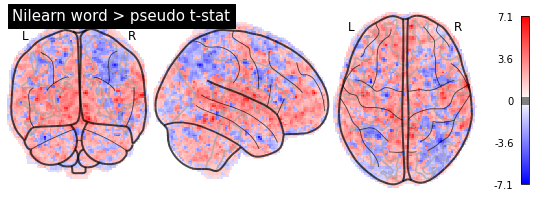

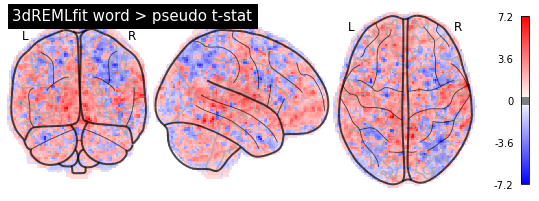

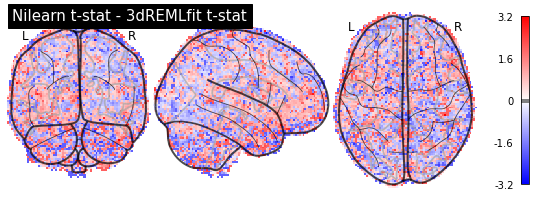

In [23]:
opa = plotting.plot_glass_brain(nl_wp_img, colorbar=True, symmetric_cbar=True, cmap='bwr', plot_abs=False)
opa.title('Nilearn word > pseudo t-stat')
opb = plotting.plot_glass_brain(rf_wp_img, colorbar=True, symmetric_cbar=True, cmap='bwr', plot_abs=False)
opb.title('3dREMLfit word > pseudo t-stat')
opc = plotting.plot_glass_brain(dif_wp_img, colorbar=True, symmetric_cbar=True, cmap='bwr', plot_abs=False)
opc.title('Nilearn t-stat - 3dREMLfit t-stat')

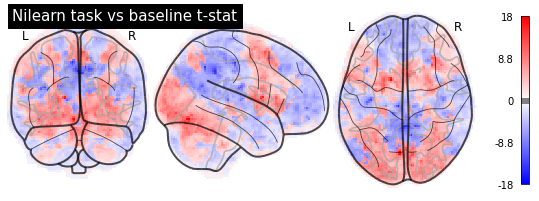

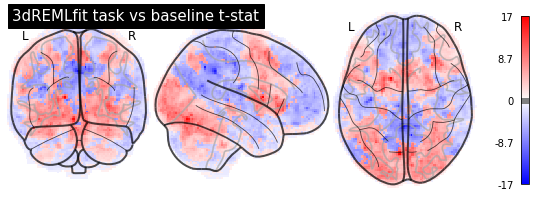

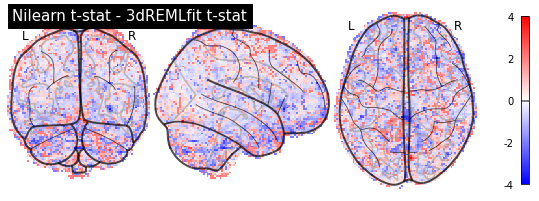

In [24]:
opa = plotting.plot_glass_brain(nl_tb_img, colorbar=True, symmetric_cbar=True, cmap='bwr', plot_abs=False)
opa.title('Nilearn task vs baseline t-stat')
opb = plotting.plot_glass_brain(rf_tb_img, colorbar=True, symmetric_cbar=True, cmap='bwr', plot_abs=False)
opb.title('3dREMLfit task vs baseline t-stat')
opc = plotting.plot_glass_brain(dif_tb_img, colorbar=True, symmetric_cbar=True, cmap='bwr', plot_abs=False)
opc.title('Nilearn t-stat - 3dREMLfit t-stat')

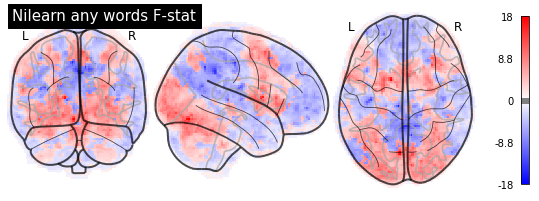

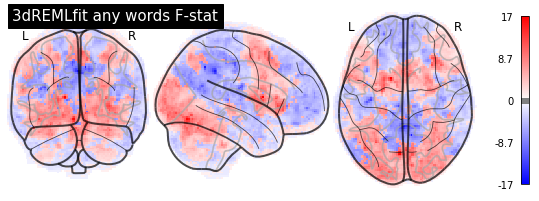

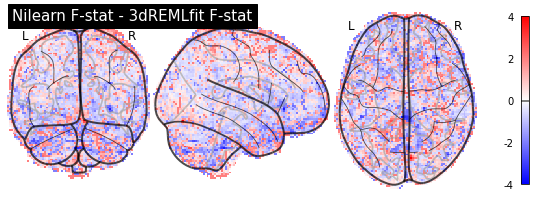

In [25]:
opa = plotting.plot_glass_brain(nl_tb_img, colorbar=True, symmetric_cbar=True, cmap='bwr', plot_abs=False)
opa.title('Nilearn any words F-stat')
opb = plotting.plot_glass_brain(rf_tb_img, colorbar=True, symmetric_cbar=True, cmap='bwr', plot_abs=False)
opb.title('3dREMLfit any words F-stat')
opc = plotting.plot_glass_brain(dif_tb_img, colorbar=True, symmetric_cbar=True, cmap='bwr', plot_abs=False)
opc.title('Nilearn F-stat - 3dREMLfit F-stat')

Results are qualitatively similar, but have some numerical differences.